In [ ]:
#|default_exp models.PatchTST

# PatchTST

This is an unofficial PyTorch implementation of PatchTST created by Ignacio Oguiza (oguiza@timeseriesAI.co) based on:

In this notebook, we are going to use a new state-of-the-art model called PatchTST (Nie et al, 2022) to create a long-term time series forecast. 



Here are some paper details:

* Nie, Y., Nguyen, N. H., Sinthong, P., & Kalagnanam, J. (2022). **A Time Series is Worth 64 Words: Long-term Forecasting with Transformers.** arXiv preprint arXiv:2211.14730.
* Official implementation:: https://github.com/yuqinie98/PatchTST

```bash
@article{Yuqietal-2022-PatchTST,
  title={A Time Series is Worth 64 Words: Long-term Forecasting with Transformers},
  author={Yuqi Nie and 
          Nam H. Nguyen and 
          Phanwadee Sinthong and 
          Jayant Kalagnanam},
  journal={arXiv preprint arXiv:2211.14730},
  year={2022}
}
```

PatchTST has shown some impressive results across some of the most widely used long-term datasets for benchmarking:

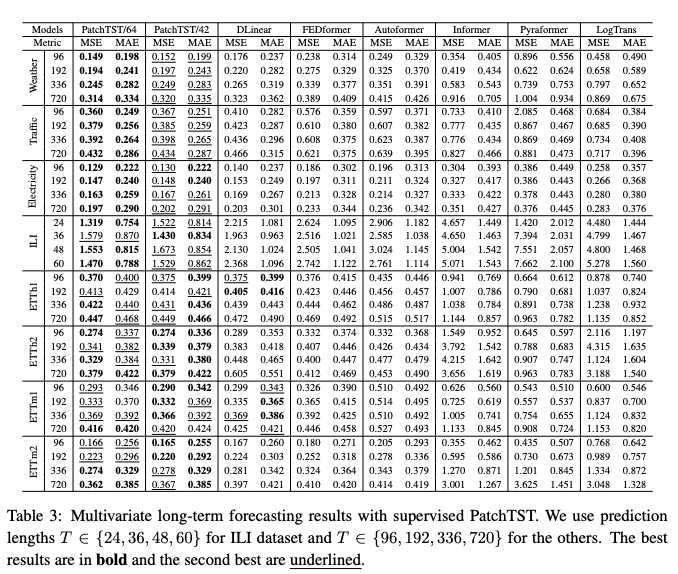

In [ ]:
#|export
import warnings
from typing import Optional
import torch
from torch import nn
import torch.nn.functional as F
from torch import Tensor
from tsai.models.layers import Transpose, get_act_fn, RevIN
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#|export
class MovingAverage(nn.Module):
    "Moving average block to highlight the trend of time series"

    def __init__(self,
         kernel_size:int,  # the size of the window
         ):
        super().__init__()
        padding_left = (kernel_size - 1) // 2
        padding_right = kernel_size - padding_left - 1
        self.padding = torch.nn.ReplicationPad1d((padding_left, padding_right))
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1)

    def forward(self, x:Tensor):
        """ 
        Args:
            x: torch.Tensor shape: [bs x seq_len x features]
        """
        return self.avg(self.padding(x))


class SeriesDecomposition(nn.Module):
    "Series decomposition block"

    def __init__(self,
         kernel_size:int,  # the size of the window
         ):
        super().__init__()
        self.moving_avg = MovingAverage(kernel_size)

    def forward(self, x:Tensor):
        """ Args:
            x: torch.Tensor shape: [bs x seq_len x features]
        """
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return residual, moving_mean

In [ ]:
#|exporti
class _ScaledDotProductAttention(nn.Module):
    r"""Scaled Dot-Product Attention module (Attention is all you need by Vaswani et al., 2017) with 
    optional residual attention from previous layer
    Realformer: Transformer likes residual attention by He et al, 2020
    """

    def __init__(self, d_model, n_heads, attn_dropout=0., res_attention=False):
        super().__init__()
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.res_attention = res_attention
        head_dim = d_model // n_heads
        self.scale = nn.Parameter(torch.tensor(
            head_dim ** -0.5), requires_grad=False)

    def forward(self, q:Tensor, k:Tensor, v:Tensor, prev:Optional[Tensor]=None):
        '''
        Input shape:
            q               : [bs x n_heads x max_q_len x d_k] # d_k = d_model // n_heads
            k               : [bs x n_heads x d_k x seq_len]   # d_k = d_model // n_heads
            v               : [bs x n_heads x seq_len x d_v]   # d_v = d_model // n_heads
            prev            : [bs x n_heads x q_len x seq_len]
        Output shape:
            output          :  [bs x n_heads x q_len x d_v]    # d_v = d_model // n_heads
            attn            : [bs x n_heads x q_len x seq_len]
            scores          : [bs x n_heads x q_len x seq_len]
        '''

        # Scaled MatMul (q, k) - similarity scores for all pairs of positions in an input sequence
        # attn_scores : [bs x n_heads x max_q_len x q_len]
        attn_scores = torch.matmul(q, k) * self.scale

        # Add pre-softmax attention scores from the previous layer (optional)
        if prev is not None:
            attn_scores = attn_scores + prev

        # normalize the attention weights
        # attn_weights   : [bs x n_heads x max_q_len x q_len]
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        # compute the new values given the attention weights
        # output: [bs x n_heads x max_q_len x d_v]
        output = torch.matmul(attn_weights, v)

        if self.res_attention:
            return output, attn_weights, attn_scores
        else:
            return output, attn_weights

In [ ]:
#|exporti
class _MultiheadAttention(nn.Module):
    def __init__(self, d_model, n_heads, d_k=None, d_v=None, res_attention=False, attn_dropout=0., proj_dropout=0., qkv_bias=True):
        "Multi Head Attention Layer"
        
        super().__init__()
        d_k = d_v = d_model // n_heads

        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v

        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=qkv_bias)

        # Scaled Dot-Product Attention (multiple heads)
        self.res_attention = res_attention
        self.sdp_attn = _ScaledDotProductAttention(
            d_model, n_heads, attn_dropout=attn_dropout, res_attention=self.res_attention)

        # Poject output
        self.to_out = nn.Sequential(
            nn.Linear(n_heads * d_v, d_model), nn.Dropout(proj_dropout))

    def forward(self, Q:Tensor, K:Optional[Tensor]=None, V:Optional[Tensor]=None, prev:Optional[Tensor]=None):
        """
        Args:
            Q:       [batch_size (bs) x max_q_len x d_model]
            K, V:    [batch_size (bs) x q_len x d_model]
            mask:    [q_len x q_len]
        """

        bs = Q.size(0)
        if K is None:
            K = Q
        if V is None:
            V = Q

        # Linear (+ split in multiple heads)
        q_s = self.W_Q(Q).view(bs, -1, self.n_heads, self.d_k).transpose(1, 2) # q_s: [bs x n_heads x max_q_len x d_k]
        k_s = self.W_K(K).view(bs, -1, self.n_heads, self.d_k).permute(0, 2, 3, 1) # k_s: [bs x n_heads x d_k x q_len] - transpose(1,2) + transpose(2,3)
        v_s = self.W_V(V).view(bs, -1, self.n_heads, self.d_v).transpose(1, 2) # v_s: [bs x n_heads x q_len x d_v]

        # Apply Scaled Dot-Product Attention (multiple heads)
        if self.res_attention:
            output, attn_weights, attn_scores = self.sdp_attn(q_s, k_s, v_s, prev=prev)
        else:
            output, attn_weights = self.sdp_attn(q_s, k_s, v_s)
        # output: [bs x n_heads x q_len x d_v], attn: [bs x n_heads x q_len x q_len], scores: [bs x n_heads x max_q_len x q_len]

        # back to the original inputs dimensions
        output = output.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v)  # output: [bs x q_len x n_heads * d_v]
        output = self.to_out(output)

        if self.res_attention:
            return output, attn_weights, attn_scores
        else:
            return output, attn_weights

In [ ]:
#|export
class Flatten_Head(nn.Module):
    def __init__(self, individual, n_vars, nf, pred_dim):
        super().__init__()
        
        if isinstance(pred_dim, (tuple, list)):
            pred_dim = pred_dim[-1]
        self.individual = individual
        self.n = n_vars if individual else 1
        self.nf, self.pred_dim = nf, pred_dim
        
        if individual:
            self.layers = nn.ModuleList()
            for i in range(self.n):
                self.layers.append(nn.Sequential(nn.Flatten(start_dim=-2), nn.Linear(nf, pred_dim)))
        else:
            self.layer = nn.Sequential(nn.Flatten(start_dim=-2), nn.Linear(nf, pred_dim))
            
    def forward(self, x:Tensor): 
        """
        Args:
            x: [bs x nvars x d_model x n_patch]
            output: [bs x nvars x pred_dim]
        """
        if self.individual: 
            x_out = []
            for i, layer in enumerate(self.layers):
                x_out.append(layer(x[:, i]))
            x = torch.stack(x_out, dim=1) 
            return x
        else: 
            return self.layer(x)

In [ ]:
#|exporti
class _TSTiEncoderLayer(nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=256, store_attn=False,
                 norm='BatchNorm', attn_dropout=0, dropout=0., bias=True, activation="gelu", res_attention=False, pre_norm=False):
        super().__init__()
        assert not d_model%n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = _MultiheadAttention(d_model, n_heads, d_k, d_v, attn_dropout=attn_dropout, 
                                             proj_dropout=dropout, res_attention=res_attention)

        # Add & Norm
        self.dropout_attn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_attn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_attn = nn.LayerNorm(d_model)

        # Position-wise Feed-Forward
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff, bias=bias),
                                get_act_fn(activation),
                                nn.Dropout(dropout),
                                nn.Linear(d_ff, d_model, bias=bias))

        # Add & Norm
        self.dropout_ffn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_ffn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_ffn = nn.LayerNorm(d_model)

        self.pre_norm = pre_norm
        self.store_attn = store_attn


    def forward(self, src:Tensor, prev:Optional[Tensor]=None):
        
        """
        Args:
            src: [bs x q_len x d_model]
        """

        # Multi-Head attention sublayer
        if self.pre_norm:
            src = self.norm_attn(src)
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(src, src, src, prev)
        else:
            src2, attn = self.self_attn(src, src, src)
        if self.store_attn:
            self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_attn(src)

        # Feed-forward sublayer
        if self.pre_norm:
            src = self.norm_ffn(src)
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_ffn(src)

        if self.res_attention:      
            return src, scores
        else:
            return src

In [ ]:
#|exporti
class _TSTiEncoder(nn.Module):  #i means channel-independent
    def __init__(self, c_in, patch_num, patch_len, n_layers=3, d_model=128, n_heads=16, d_k=None, d_v=None, 
                 d_ff=256, norm='BatchNorm', attn_dropout=0., dropout=0., act="gelu", store_attn=False, 
                 res_attention=True, pre_norm=False):
        
        super().__init__()
        
        self.patch_num = patch_num
        self.patch_len = patch_len
        
        # Input encoding
        q_len = patch_num
        self.W_P = nn.Linear(patch_len, d_model) # Eq 1: projection of feature vectors onto a d-dim vector space
        self.seq_len = q_len

        # Positional encoding
        W_pos = torch.empty((q_len, d_model))
        nn.init.uniform_(W_pos, -0.02, 0.02)
        self.W_pos = nn.Parameter(W_pos)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.layers = nn.ModuleList([_TSTiEncoderLayer(q_len, d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm,
                                                      attn_dropout=attn_dropout, dropout=dropout,
                                                      activation=act, res_attention=res_attention,
                                                      pre_norm=pre_norm, store_attn=store_attn) for i in range(n_layers)])
        self.res_attention = res_attention

        
    def forward(self, x:Tensor):
        """
        Args:
            x: [bs x nvars x patch_len x patch_num]
        """
        
        n_vars = x.shape[1]
        # Input encoding
        x = x.permute(0,1,3,2)                                                   # x: [bs x nvars x patch_num x patch_len]
        x = self.W_P(x)                                                          # x: [bs x nvars x patch_num x d_model]

        x = torch.reshape(x, (x.shape[0]*x.shape[1],x.shape[2],x.shape[3]))      # x: [bs * nvars x patch_num x d_model]
        x = self.dropout(x + self.W_pos)                                         # x: [bs * nvars x patch_num x d_model]

        # Encoder
        if self.res_attention:
            scores = None
            for mod in self.layers: 
                x, scores = mod(x, prev=scores)
        else:
            for mod in self.layers: x = mod(x)
        x = torch.reshape(x, (-1,n_vars,x.shape[-2],x.shape[-1]))                # x: [bs x nvars x patch_num x d_model]
        x = x.permute(0,1,3,2)                                                   # x: [bs x nvars x d_model x patch_num]
        
        return x 

In [ ]:
#|exporti
class _PatchTST_backbone(nn.Module):
    def __init__(self, c_in, seq_len, pred_dim, patch_len, stride, 
                 n_layers=3, d_model=128, n_heads=16, d_k=None, d_v=None,
                 d_ff=256, norm='BatchNorm', attn_dropout=0., dropout=0., 
                 act="gelu", res_attention=True, pre_norm=False, store_attn=False,
                 padding_patch=True, individual=False, 
                 revin=True, affine=True, subtract_last=False):
        
        super().__init__()
        
        # RevIn
        self.revin = revin
        self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last)

        # # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        patch_num = int((seq_len - patch_len) / stride + 1) + 1
        self.patch_num = patch_num
        self.padding_patch_layer = nn.ReplicationPad1d((stride, 0)) # original padding at the end
        
        # Unfold
        self.unfold = nn.Unfold(kernel_size=(1, patch_len), stride=stride)
        self.patch_len = patch_len

        # Backbone 
        self.backbone = _TSTiEncoder(c_in, patch_num=patch_num, patch_len=patch_len,
                                     n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff,
                                     attn_dropout=attn_dropout, dropout=dropout, act=act,
                                     res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn)

        # Head
        self.head_nf = d_model * patch_num
        self.n_vars = c_in
        self.individual = individual
        self.head = Flatten_Head(self.individual, self.n_vars, self.head_nf, pred_dim)
        
    
    def forward(self, z:Tensor): 
        """
        Args:
            z: [bs x c_in x seq_len]
        """
        
        # norm
        if self.revin:
            z = self.revin_layer(z, torch.tensor(True, dtype=torch.bool))
            
        # do patching
        z = self.padding_patch_layer(z)
        b, c, s = z.size()
        z = z.reshape(-1, 1, 1, s)
        z = self.unfold(z)
        z = z.permute(0, 2, 1).reshape(b, c, -1, self.patch_len).permute(0, 1, 3, 2)
        
        # model
        z = self.backbone(z) # z: [bs x nvars x d_model x patch_num]
        z = self.head(z) # z: [bs x nvars x pred_dim] 
        
        # denorm
        if self.revin:
            z = self.revin_layer(z, torch.tensor(False, dtype=torch.bool))
        return z

In [ ]:
#|export
class PatchTST(nn.Module):
    def __init__(self,
         c_in,  # number of input channels
         c_out, # used for compatibility
         seq_len,  # input sequence length
         pred_dim=None,  # prediction sequence length
         n_layers=2,  # number of encoder layers
         n_heads=8,  # number of heads
         d_model=512,  # dimension of model
         d_ff=2048,  # dimension of fully connected network (fcn)
         dropout=0.05,  # dropout applied to all linear layers in the encoder
         attn_dropout=0.,  # dropout applied to the attention scores
         patch_len=16,  # patch_len
         stride=8,  # stride
         padding_patch=True,  # flag to indicate if padded is added if necessary
         revin=True,  # RevIN
         affine=False,  # RevIN affine
         individual=False,  # individual head
         subtract_last=False,  # subtract_last
         decomposition=False,  # apply decomposition
         kernel_size=25,  # decomposition kernel size
         activation="gelu", # activation function of intermediate layer, relu or gelu.
         norm='BatchNorm',  # type of normalization layer used in the encoder
         pre_norm=False, # flag to indicate if normalization is applied as the first step in the sublayers
         res_attention=True,  # flag to indicate if Residual MultiheadAttention should be used
         store_attn=False,  # can be used to visualize attention weights
         ):

        super().__init__()

        # model
        if pred_dim is None:
            pred_dim = seq_len
        
        self.decomposition = decomposition
        if self.decomposition:
            self.decomp_module = SeriesDecomposition(kernel_size)
            self.model_trend = _PatchTST_backbone(c_in=c_in, seq_len=seq_len, pred_dim=pred_dim,
                                                  patch_len=patch_len, stride=stride, n_layers=n_layers, d_model=d_model,
                                                  n_heads=n_heads, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout,
                                                  dropout=dropout, act=activation, res_attention=res_attention, pre_norm=pre_norm, 
                                                  store_attn=store_attn, padding_patch=padding_patch, 
                                                  individual=individual, revin=revin, affine=affine, subtract_last=subtract_last)
            self.model_res = _PatchTST_backbone(c_in=c_in, seq_len=seq_len, pred_dim=pred_dim, 
                                                patch_len=patch_len, stride=stride, n_layers=n_layers, d_model=d_model,
                                                n_heads=n_heads, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout,
                                                dropout=dropout, act=activation, res_attention=res_attention, pre_norm=pre_norm, 
                                                store_attn=store_attn, padding_patch=padding_patch, 
                                                individual=individual, revin=revin, affine=affine, subtract_last=subtract_last)
            self.patch_num = self.model_trend.patch_num
        else:
            self.model = _PatchTST_backbone(c_in=c_in, seq_len=seq_len, pred_dim=pred_dim, 
                                            patch_len=patch_len, stride=stride, n_layers=n_layers, d_model=d_model,
                                            n_heads=n_heads, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout,
                                            dropout=dropout, act=activation, res_attention=res_attention, pre_norm=pre_norm, 
                                            store_attn=store_attn, padding_patch=padding_patch, 
                                            individual=individual, revin=revin, affine=affine, subtract_last=subtract_last)
            self.patch_num = self.model.patch_num

    def forward(self, x):
        """Args:
            x: rank 3 tensor with shape [batch size x features x sequence length]
        """
        if self.decomposition:
            res_init, trend_init = self.decomp_module(x)
            res = self.model_res(res_init)
            trend = self.model_trend(trend_init)
            x = res + trend
        else:
            x = self.model(x)
        return x

In [ ]:
from fastcore.test import test_eq
from tsai.models.utils import count_parameters

bs = 32
c_in = 9  # aka channels, features, variables, dimensions
c_out = 1
seq_len = 60
pred_dim = 20

xb = torch.randn(bs, c_in, seq_len)

arch_config=dict(
        n_layers=3,  # number of encoder layers
        n_heads=16,  # number of heads
        d_model=128,  # dimension of model
        d_ff=256,  # dimension of fully connected network (fcn)
        attn_dropout=0.,
        dropout=0.2,  # dropout applied to all linear layers in the encoder
        patch_len=16,  # patch_len
        stride=8,  # stride
    )

model = PatchTST(c_in, c_out, seq_len, pred_dim, **arch_config)
test_eq(model.to(xb.device)(xb).shape, [bs, c_in, pred_dim])
print(f'model parameters: {count_parameters(model)}')

model parameters: 418470


### Test conversion to Torchscript

In [ ]:
import gc
import os
import torch
import torch.nn as nn
from fastcore.test import test_eq, test_close


bs = 1
new_bs = 8
c_in = 3
c_out = 1
seq_len = 96
pred_dim = 20

# module
model = PatchTST(c_in, c_out, seq_len, pred_dim)
model = model.eval()

# input data
inp = torch.rand(bs, c_in, seq_len)
new_inp = torch.rand(new_bs, c_in, seq_len)

# original
try:
    output = model(inp)
    new_output = model(new_inp)
    print(f'{"original":10}: ok')
except:
    print(f'{"original":10}: failed')

# tracing
try:
    traced_model = torch.jit.trace(model, inp)
    file_path = f"_test_traced_model.pt"
    torch.jit.save(traced_model, file_path)
    traced_model = torch.jit.load(file_path)
    test_eq(output, traced_model(inp))
    test_eq(new_output, traced_model(new_inp))
    os.remove(file_path)
    del traced_model
    gc.collect()
    print(f'{"tracing":10}: ok')
except:
    print(f'{"tracing":10}: failed')

# scripting
try:
    scripted_model = torch.jit.script(model)
    file_path = f"_test_scripted_model.pt"
    torch.jit.save(scripted_model, file_path)
    scripted_model = torch.jit.load(file_path)
    test_eq(output, scripted_model(inp))
    test_eq(new_output, scripted_model(new_inp))
    os.remove(file_path)
    del scripted_model
    gc.collect()
    print(f'{"scripting":10}: ok')
except:
    print(f'{"scripting":10}: failed')

original  : ok
tracing   : ok
scripting : failed


### Test conversion to onnx

In [ ]:
#|onnx
try:
    import onnx
    import onnxruntime as ort
    
    try:
        file_path = "_model_cpu.onnx"
        torch.onnx.export(model.cpu(),               # model being run
                        inp,                       # model input (or a tuple for multiple inputs)
                        file_path,                 # where to save the model (can be a file or file-like object)
                        input_names = ['input'],   # the model's input names
                        output_names = ['output'], # the model's output names
                        dynamic_axes={
                            'input'  : {0 : 'batch_size'}, 
                            'output' : {0 : 'batch_size'}} # variable length axes
                        )


        # Load the model and check it's ok
        onnx_model = onnx.load(file_path)
        onnx.checker.check_model(onnx_model)
        del onnx_model
        gc.collect()

        # New session
        ort_sess = ort.InferenceSession(file_path)
        output_onnx = ort_sess.run(None, {'input': inp.numpy()})[0]
        test_close(output.detach().numpy(), output_onnx)
        new_output_onnx = ort_sess.run(None, {'input': new_inp.numpy()})[0]
        test_close(new_output.detach().numpy(), new_output_onnx)
        os.remove(file_path)
        print(f'{"onnx":10}: ok')
    except:
        print(f'{"onnx":10}: failed')

except ImportError:
    print('onnx and onnxruntime are not installed. Please install them to run this test')

onnx      : ok


In [ ]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

<IPython.core.display.Javascript object>

/Users/nacho/notebooks/tsai/nbs/050b_models.PatchTST.ipynb saved at 2023-02-06 20:14:15
Correct notebook to script conversion! 😃
Monday 06/02/23 20:14:18 CET
